## Description:
# Model -2
- se_resnext50_32x4d
- Data Augmentation(224x224)
- Upsampling
- StratifiedKFold CV

# Setup Workspace

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd drive/My Drive/Colab Notebooks

/content/drive/My Drive/Colab Notebooks


In [0]:
#  from google.colab import files
#  files.upload()

In [0]:
 !pip install -q kaggle

In [0]:
 !mkdir -p ~/.kaggle
 !cp kaggle.json ~/.kaggle/

In [0]:
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
cd /content/

/content


In [8]:
!kaggle datasets download -d hakymulla/cgiar-computer-vision-for-crop-disease

100% 2.99G/3.00G [00:56<00:00, 46.5MB/s]
100% 3.00G/3.00G [00:56<00:00, 56.9MB/s]


In [0]:
%%capture
!unzip cgiar-computer-vision-for-crop-disease.zip
!rm cgiar-computer-vision-for-crop-disease.zip

In [61]:
%%capture
!pip install -U catalyst
!pip install albumentations
!pip install pretrainedmodels

Restart runtime

In [0]:
# plotly configuration
import IPython

def configure_plotly_browser_state():
    display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))


IPython.get_ipython().events.register('pre_run_cell', configure_plotly_browser_state)

In [23]:
%load_ext tensorboard

In [3]:
# a gif image is causing some problem while training so let's get rid of that
!rm ICLR/train/train/leaf_rust/*.gif

In [1]:
!nvidia-smi

Sat Mar  7 09:20:15 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Importing Packages

In [1]:
from typing import Callable, List, Tuple
import numpy as np
import pandas as pd

import os
import torch
import catalyst

from catalyst.dl import utils
from catalyst.utils import get_dataset_labeling

print(f"torch: {torch.__version__}, catalyst: {catalyst.__version__}")

os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # "" - CPU, "0" - 1 GPU, "0,1" - MultiGPU

SEED = 42
utils.set_global_seed(SEED)
utils.prepare_cudnn(deterministic=True)

alchemy not available, to install alchemy, run `pip install alchemy-catalyst`.
alchemy not available, to install alchemy, run `pip install alchemy-catalyst`.


torch: 1.4.0, catalyst: 20.03


/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192

/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning:

can't resolve package from __spec__ or __package__, falling back on __name__ and __path__

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/backend.py:5747: ResourceWarning:

unclosed file <_io.TextIOWrapper name='/root/.keras/keras.json' mode='r' encoding='UTF-8'>



# Dataset Preprocessing

In [0]:
df_with_labels = pd.read_csv('train.csv')
tag_to_label = get_dataset_labeling(df_with_labels, "class")
class_names = [
    name for name, id_ in sorted(tag_to_label.items(), key=lambda x: x[1])
]

In [3]:
tag_to_label, class_names

({'healthy_wheat': 0, 'leaf_rust': 1, 'stem_rust': 2},
 ['healthy_wheat', 'leaf_rust', 'stem_rust'])

In [4]:
train_folds = [1,2,3,4]
valid_fold = [0]

train_data = df_with_labels[df_with_labels.kfold.isin(train_folds)].reset_index(drop=True)
train_data.drop(columns=['kfold'], inplace=True)
valid_data = df_with_labels[df_with_labels.kfold.isin(valid_fold)].reset_index(drop=True)
valid_data.drop(columns=['kfold'], inplace=True)

train_data.head()

class                                    filepath  label
0  healthy_wheat  ICLR/train/train/healthy_wheat/CHJDTJ.jfif      0
1  healthy_wheat   ICLR/train/train/healthy_wheat/FC45DX.jpg      0
2  healthy_wheat   ICLR/train/train/healthy_wheat/MEWKD5.jpg      0
3  healthy_wheat   ICLR/train/train/healthy_wheat/FSES5U.jpg      0
4  healthy_wheat  ICLR/train/train/healthy_wheat/R1GKEP.jfif      0

In [5]:
valid_data.head()

class                                   filepath  label
0      stem_rust      ICLR/train/train/stem_rust/1CQ95E.JPG      2
1      stem_rust      ICLR/train/train/stem_rust/7QBIPY.jpg      2
2      leaf_rust      ICLR/train/train/leaf_rust/1Z2P44.jpg      1
3  healthy_wheat  ICLR/train/train/healthy_wheat/ZB9CAK.jpg      0
4      stem_rust      ICLR/train/train/stem_rust/4PS17R.jpg      2

In [0]:
train_data, valid_data = (
    train_data.to_dict('records'), valid_data.to_dict('records')
)

In [0]:
from catalyst.dl import utils
from catalyst.data import ImageReader, ScalarReader, ReaderCompose


num_classes = len(class_names)

# ReaderCompose collects different Readers into one pipeline
open_fn = ReaderCompose([
    
    # Reads images from the `rootpath` folder 
    # using the key `input_key =" filepath "` (here should be the filename)
    # and writes it to the output dictionary by `output_key="features"` key
    ImageReader(
        input_key="filepath",
        output_key="features",
        rootpath=None
    ),
    
    # Reads a number from our dataframe 
    # by the key `input_key =" label "` to np.long
    # and writes it to the output dictionary by `output_key="targets"` key
    ScalarReader(
        input_key="label",
        output_key="targets",
        default_value=-1,
        dtype=np.int64
    ),
    
    # Same as above, but with one encoding
    ScalarReader(
        input_key="label",
        output_key="targets_one_hot",
        default_value=-1,
        dtype=np.int64, 
        one_hot_classes=num_classes
    )
])

# Augmentations

In [8]:
import albumentations as albu
from albumentations.pytorch import ToTensor

BORDER_CONSTANT = 0
BORDER_REFLECT = 2

def pre_transforms(image_size=224):
    # Convert the image to a square of size image_size x image_size
    # (keeping aspect ratio)
    result = [
        albu.LongestMaxSize(max_size=image_size),
        albu.PadIfNeeded(image_size, image_size, border_mode=BORDER_CONSTANT)
    ]
    
    return result

def hard_transforms():
    result = [
        # Random shifts, stretches and turns with a 50% probability
        albu.ShiftScaleRotate( 
            shift_limit=0.1,
            scale_limit=0.1,
            rotate_limit=15,
            border_mode=BORDER_REFLECT,
            p=0.5
        ),
        albu.VerticalFlip(),
        albu.IAAPerspective(scale=(0.02, 0.05), p=0.3),
        # Random brightness / contrast with a 30% probability
        albu.RandomBrightnessContrast(
            brightness_limit=0.2, contrast_limit=0.2, p=0.3
        ),
        # Random gamma changes with a 30% probability
        albu.RandomGamma(gamma_limit=(85, 115), p=0.3),
        # Randomly changes the hue, saturation, and color value of the input image
        albu.HueSaturationValue(p=0.3),
        albu.JpegCompression(quality_lower=80),
    ]
    
    return result

def post_transforms():
    # we use ImageNet image normalization
    # and convert it to torch.Tensor
    return [albu.Normalize(), ToTensor()]

def compose(transforms_to_compose):
    # combine all augmentations into one single pipeline
    result = albu.Compose([
      item for sublist in transforms_to_compose for item in sublist
    ])
    return result

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject

/usr/local/lib/python3.6/dist-packages/torchvision/extension.py:11: ResourceWarning:

unclosed file <_io.BufferedReader name='/usr/local/lib/python3.6/dist-packages/torchvision/_C.so'>



In [0]:
from catalyst.data import Augmentor


train_transforms = compose([
    pre_transforms(), 
    hard_transforms(), 
    post_transforms()
])
valid_transforms = compose([pre_transforms(), post_transforms()])

show_transforms = compose([pre_transforms(), hard_transforms()])

# Takes an image from the input dictionary by the key `dict_key` 
# and performs `train_transforms` on it.
train_data_transforms = Augmentor(
    dict_key="features",
    augment_fn=lambda x: train_transforms(image=x)["image"]
)


# Similarly for the validation part of the dataset. 
# we only perform squaring, normalization and ToTensor
valid_data_transforms = Augmentor(
    dict_key="features",
    augment_fn=lambda x: valid_transforms(image=x)["image"]
)

In [0]:
from catalyst.utils import imread
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt

def show_examples(images: List[Tuple[str, np.ndarray]]):
    _indexes = [(i, j) for i in range(2) for j in range(2)]
    
    f, ax = plt.subplots(2, 2, figsize=(9, 9))
    for (i, j), (title, img) in zip(_indexes, images):
        ax[i, j].imshow(img)
        ax[i, j].set_title(title)
    f.tight_layout()

def read_random_images(paths: List[Path]) -> List[Tuple[str, np.ndarray]]:
    data = np.random.choice(paths, size=4)
    result = []
    for d in data:
        title = f"{d.parent.name}: {d.name}"
        _image = imread(d)
        result.append((title, _image))
    
    return result

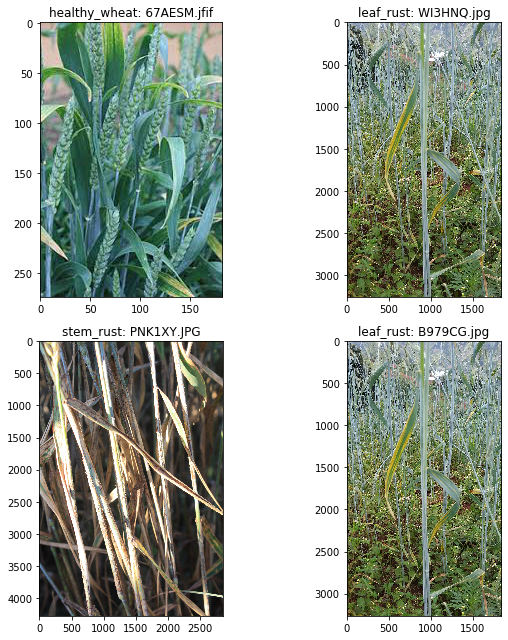

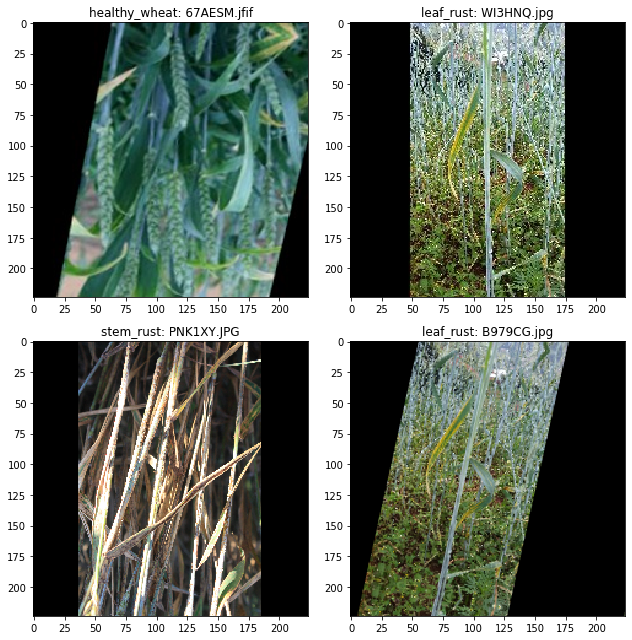

In [11]:
ROOT = 'ICLR'
ALL_IMAGES = list(Path(ROOT).glob("train/train/*/*"))
ALL_IMAGES = list(filter(lambda x: not x.name.startswith("."), ALL_IMAGES))

images = read_random_images(ALL_IMAGES)
show_examples(images)
images = [
    (title, show_transforms(image=i)["image"])
    for (title, i) in images
]
show_examples(images)

# Data Loaders

In [12]:
import collections

is_fp16_used = False

def get_loaders(
    open_fn: Callable,
    train_transforms_fn,
    valid_transforms_fn,
    batch_size: int = 64, 
    num_workers: int = 4,
    sampler = None
) -> collections.OrderedDict:
    """
    Args:
        open_fn: Reader for reading data from a dataframe
        train_transforms_fn: Augmentor for train part
        valid_transforms_fn: Augmentor for valid part
        batch_size: batch size
        num_workers: How many subprocesses to use to load data,
        sampler: An object of the torch.utils.data.Sampler class 
            for the dataset data sampling strategy specification
    """
    train_loader = utils.get_loader(
        train_data,
        open_fn=open_fn,
        dict_transform=train_transforms_fn,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=sampler is None, # shuffle data only if Sampler is not specified (PyTorch requirement)
        sampler=sampler,
        drop_last=False,
    )

    valid_loader = utils.get_loader(
        valid_data,
        open_fn=open_fn,
        dict_transform=valid_transforms_fn,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False, 
        sampler=None,
        drop_last=False,
    )

    # Catalyst expects an ordered dictionary with train/valid/infer loaders. 
    # The number of loaders can vary.
    # For example, it can easily handle even some complex logic like:
    # loaders["train_dataset1"] = train_loader_1
    # loaders["train_dataset2"] = train_loader_2
    # ....
    # loaders["valid_1"] = valid_loader_1
    # loaders["valid_2"] = valid_loader_2
    # ...
    # loaders["infer_1"] = infer_loader_1
    # loaders["infer_2"] = infer_loader_2
    # ...
    
    loaders = collections.OrderedDict()
    loaders["train"] = train_loader
    loaders["valid"] = valid_loader

    return loaders

if is_fp16_used:
    batch_size = 128
else:
    batch_size = 64

print(f"batch_size: {batch_size}")

loaders = get_loaders(
    open_fn=open_fn, 
    train_transforms_fn=train_data_transforms,
    valid_transforms_fn=valid_data_transforms,
    batch_size=batch_size,
)


batch_size: 64


# Model

In [0]:
import pretrainedmodels

In [14]:
pretrainedmodels.pretrained_settings['se_resnext50_32x4d']

{'imagenet': {'input_range': [0, 1],
  'input_size': [3, 224, 224],
  'input_space': 'RGB',
  'mean': [0.485, 0.456, 0.406],
  'num_classes': 1000,
  'std': [0.229, 0.224, 0.225],
  'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth'}}

In [0]:
def get_model(no_classes = 3):
    model = pretrainedmodels.__dict__['se_resnext50_32x4d'](num_classes=1000, pretrained='imagenet')
    model.last_linear = torch.nn.Linear(in_features=2048, out_features=no_classes, bias=True)
    return model

In [0]:
model = get_model()

In [17]:
model

SENet(
  (layer0): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  )
  (layer1): Sequential(
    (0): SEResNeXtBottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (se_module): SEModule(
     

# Training

In [0]:
import torch
import torch.nn as nn
from catalyst.contrib.nn import FocalLossMultiClass, OneCycleLRWithWarmup

num_epochs = 11

# as we are working on basic classification problem (no multi-class/multi-label)
# let's use standard CE loss
criterion = FocalLossMultiClass()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = OneCycleLRWithWarmup(
    optimizer, 
    num_steps=num_epochs, 
    lr_range=(0.001, 3e-4),
    warmup_steps=1
)

In [19]:
from catalyst.dl import SupervisedRunner

logdir = "./logs/classification"

device = utils.get_device()
print(f"device: {device}")

if is_fp16_used:
    fp16_params = dict(opt_level="O1") # params for FP16
else:
    fp16_params = None

print(f"FP16 params: {fp16_params}")

runner = SupervisedRunner(device=device,input_target_key="targets_one_hot")

device: cuda
FP16 params: None


In [20]:
# as we are working on classification task
from catalyst.dl.callbacks import AccuracyCallback, AUCCallback, F1ScoreCallback, CheckpointCallback

runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    # We can specify the callbacks list for the experiment;
    # For this task, we will check accuracy, AUC and F1 metrics
    callbacks=[
        # CheckpointCallback(resume=f"logs/classification/checkpoints/last.pth"),
        AccuracyCallback(num_classes=num_classes),
        AUCCallback(
            num_classes=num_classes,
            input_key="targets_one_hot",
            class_names=class_names
        ),
        F1ScoreCallback(
            input_key="targets_one_hot",
            activation="Softmax"
        )
    ],
    # path to save logs
    logdir=logdir,
    
    num_epochs=num_epochs,
    
    # save our best checkpoint by AUC metric
    main_metric="auc/_mean",
    # AUC needs to be maximized.
    minimize_metric=False,
    
    # for FP16. It uses the variable from the very first cell
    fp16=fp16_params,
    
    # for external monitoring tools, like Alchemy
    monitoring_params=None,

    # prints train logs
    verbose=True
)

1/11 * Epoch (train):   0% 0/14 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/catalyst/utils/metrics/f1_score.py:31: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



1/11 * Epoch (train): 100% 14/14 [01:55<00:00,  8.25s/it, _timer/_fps=30.954, _timer/batch_time=2.068, _timer/data_time=1.431, _timer/model_time=0.636, accuracy01=0.828, f1_score=0.624, loss=0.097]
1/11 * Epoch (valid): 100% 3/3 [00:24<00:00,  8.03s/it, _timer/_fps=35.494, _timer/batch_time=1.803, _timer/data_time=1.183, _timer/model_time=0.620, accuracy01=0.547, f1_score=0.549, loss=0.596]
[2020-03-07 09:25:23,721] 
1/11 * Epoch 1 (train): _timer/_fps=20.0878 | _timer/batch_time=8.1349 | _timer/data_time=7.1644 | _timer/model_time=0.9705 | accuracy01=0.7109 | auc/_mean=0.8471 | auc/class_healthy_wheat=0.9182 | auc/class_leaf_rust=0.7929 | auc/class_stem_rust=0.8302 | f1_score=0.5786 | loss=0.1517
1/11 * Epoch 1 (valid): _timer/_fps=46.2412 | _timer/batch_time=7.9913 | _timer/data_time=7.3677 | _timer/model_time=0.6235 | accuracy01=0.5469 | auc/_mean=0.7258 | auc/class_healthy_wheat=0.8167 | auc/class_leaf_rust=0.5984 | auc/class_stem_rust=0.7625 | f1_score=0.5508 | loss=0.5525
2/11 * 

In [28]:
utils.plot_metrics(
    logdir=logdir, 
    # specify which metrics we want to plot
    metrics=["loss", "accuracy01", "auc/_mean", "f1_score", "_base/lr"]
)

Plotly has some issues running in colab...

In [25]:
!ls -lh /content/logs/classification/checkpoints/

total 1.2G
-rw-r--r-- 1 root root 293M Mar  7 09:47 best_full.pth
-rw-r--r-- 1 root root  98M Mar  7 09:47 best.pth
-rw-r--r-- 1 root root 293M Mar  7 09:50 last_full.pth
-rw-r--r-- 1 root root  98M Mar  7 09:50 last.pth
-rw-r--r-- 1 root root 7.7K Mar  7 09:50 _metrics.json
-rw-r--r-- 1 root root 293M Mar  7 09:47 train.10_full.pth
-rw-r--r-- 1 root root  98M Mar  7 09:47 train.10.pth


In [26]:
!cp logs/classification/checkpoints/best_full.pth drive/My\ Drive/DS/wheat_rust/model2_best_full.pth
!cp logs/classification/checkpoints/best.pth drive/My\ Drive/DS/wheat_rust/model2_best.pth